In [1]:
!pip install pandera --upgrade

In [2]:
!pip install ipykernel==5.5.6 notebook==6.5.5

In [3]:
# top k items to recommend
TOP_K = 10

# Model parameters
EPOCHS = 50
BATCH_SIZE = 256

SEED = 42

## Prepare Dataset

In [4]:
import pandas as pd

df_D = pd.read_csv("tn_visit_area_info_travel_D.csv")
df_E = pd.read_csv("tn_visit_area_info_travel.csv")

merged_df = pd.concat([df_D, df_E], axis=0, ignore_index=True)
print(merged_df.shape)
merged_df.head()

(22552, 23)


,VISIT_AREA_ID,TRAVEL_ID,VISIT_ORDER,VISIT_AREA_NM,VISIT_START_YMD,VISIT_END_YMD,ROAD_NM_ADDR,LOTNO_ADDR,X_COORD,Y_COORD,...,POI_NM,RESIDENCE_TIME_MIN,VISIT_AREA_TYPE_CD,REVISIT_YN,VISIT_CHC_REASON_CD,LODGING_TYPE_CD,DGSTFN,REVISIT_INTENTION,RCMDTN_INTENTION,SGG_CD
0,2210300003,a_a008632,7,송도센트럴파크,2022-10-30,2022-10-30,NaN,인천 연수구 송도동 24-5,126.638630,37.39306396,...,스트롤링가든브릿지,120.0,1,N,1.0,NaN,4.0,5.0,4.0,NaN
1,2210220007,d_d004269,11,원앙폭포,2022-10-22,2022-10-22,제주특별자치도 서귀포시 돈내코로 137,제주특별자치도 서귀포시 상효동 1463,126.581330,33.30017689,...,NaN,30.0,1,N,9.0,NaN,3.0,2.0,3.0,NaN
2,2209070004,c_c000751,11,쏠비치진도 인피니티풀,2022-09-07,2022-09-07,전남 진도군 의신면 송군길 30-40,전남 진도군 의신면 초사리 1204,126.327957,34.40073398,...,NaN,480.0,6,N,5.0,NaN,5.0,5.0,5.0,NaN
3,2208200006,d_d000233,18,소노캄제주 수영장,2022-08-20,2022-08-20,일주동로6347-17,제주특별자치도 서귀포시 표선면,126.792098,33.3055558,...,NaN,120.0,6,N,7.0,NaN,4.0,4.0,4.0,50130.0
4,2208260005,d_d000480,18,정방폭포,2022-08-26,2022-08-26,NaN,제주특별자치도 서귀포시 동홍동 299-3,126.571605,33.24499661,...,정방폭포,30.0,1,Y,2.0,NaN,5.0,5.0,5.0,NaN


In [5]:
item_type_df = merged_df[['VISIT_AREA_ID', 'VISIT_AREA_TYPE_CD']]
item_type_df = item_type_df[item_type_df['VISIT_AREA_TYPE_CD'].notna()]
item_type_df.shape

(22552, 2)

In [6]:
import pandas as pd

df_D = pd.read_csv("tn_visit_area_info_travel_D.csv")

# df.columns
df_D = df_D[['TRAVEL_ID', 'VISIT_AREA_ID', 'REVISIT_INTENTION', 'VISIT_START_YMD', 'VISIT_AREA_TYPE_CD']]
df_D = df_D.dropna()
df_D.rename(columns={
    'TRAVEL_ID': 'userID',
    'VISIT_AREA_ID': 'itemID',
    'REVISIT_INTENTION': 'rating',
    'VISIT_START_YMD': 'timestamp',
    'VISIT_AREA_TYPE_CD': 'itemType'
}, inplace=True)
df_D.shape

(11266, 5)

In [7]:
import pandas as pd

df_E = pd.read_csv("tn_visit_area_info_travel.csv")

# df.columns
df_E = df_E[['TRAVEL_ID', 'VISIT_AREA_ID', 'REVISIT_INTENTION', 'VISIT_START_YMD', 'VISIT_AREA_TYPE_CD']]
df_E = df_E.dropna()
df_E.rename(columns={
    'TRAVEL_ID': 'userID',
    'VISIT_AREA_ID': 'itemID',
    'REVISIT_INTENTION': 'rating',
    'VISIT_START_YMD': 'timestamp',
    'VISIT_AREA_TYPE_CD': 'itemType'
}, inplace=True)
# columns = ['userID', 'itemID', 'rating', 'timestamp']
# df.columns = columns
df_E.shape

(11266, 5)

In [8]:
df = pd.concat([df_D, df_E], axis=0, ignore_index=True)
df.to_csv("tn_visit_area_info_total.csv", index=False)
df.shape

(22532, 5)

In [9]:
df = df[df['itemType'].notna()]
df.shape

(22532, 5)

In [10]:
df['userID'] = pd.factorize(df['userID'])[0]
df['rating'] = df['rating'].replace('', 0).astype(float)

In [11]:
df.shape

(22532, 5)

## Add Item Feature Modality

In [12]:
item_type_df = df[['itemID', 'itemType']]
df = df.drop('itemType', axis=1)
print(item_type_df.shape)
print(df.shape)

(22532, 2)
(22532, 4)


In [13]:
# Make a list of (user, item, rating) tuples
dataset = []
cornac_df = df[['userID', 'itemID', 'rating']]

for index, row in cornac_df.iterrows():
    dataset.append((row['userID'], row['itemID'], row['rating']))

dataset[:10]

[(0.0, 2210300003.0, 5.0),
 (1.0, 2210220007.0, 2.0),
 (2.0, 2209070004.0, 5.0),
 (3.0, 2208200006.0, 4.0),
 (4.0, 2208260005.0, 5.0),
 (5.0, 2211060002.0, 5.0),
 (6.0, 2210040001.0, 4.0),
 (7.0, 2210270003.0, 5.0),
 (8.0, 2210270002.0, 3.0),
 (9.0, 2211130002.0, 3.0)]

In [14]:
item_type_df.head()

,itemID,itemType
0,2210300003,1
1,2210220007,1
2,2209070004,6
3,2208200006,6
4,2208260005,1


In [15]:
# ITEM Feature Modality 생성 작업
# 현재 선정한 feature: 장소 카테고리 타입

# One-Hot Encoding 수행
item_features = pd.get_dummies(item_type_df['itemType'], prefix='type')

# itemID와 One-Hot Encoding된 특징 연결
item_features = pd.concat([item_type_df['itemID'], item_features], axis=1)

# 아이템별 feature 데이터를 딕셔너리 형태로 변환
item_feature_dict = item_features.set_index('itemID').T.to_dict('list')

<ipython-input-15-e83b3d887508>:11: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  item_feature_dict = item_features.set_index('itemID').T.to_dict('list')


In [16]:
print(item_feature_dict)

{2210300003: [True, False, False, False, False, False, False, False], 2210220007: [False, True, False, False, False, False, False, False], 2209070004: [False, False, True, False, False, False, False, False], 2208200006: [True, False, False, False, False, False, False, False], 2208260005: [False, False, False, True, False, False, False, False], 2211060002: [True, False, False, False, False, False, False, False], 2210040001: [False, False, False, True, False, False, False, False], 2210270003: [True, False, False, False, False, False, False, False], 2210270002: [True, False, False, False, False, False, False, False], 2211130002: [True, False, False, False, False, False, False, False], 2210250003: [False, True, False, False, False, False, False, False], 2210160004: [False, True, False, False, False, False, False, False], 2210230002: [True, False, False, False, False, False, False, False], 2210290003: [False, False, False, True, False, False, False, False], 2210220001: [True, False, False, 

## Add User Feature Modality

In [45]:
df = pd.read_csv("tn_visit_area_info_total.csv")
df.head()

,userID,itemID,rating,timestamp,itemType
0,a_a008632,2210300003,5.0,2022-10-30,1
1,d_d004269,2210220007,2.0,2022-10-22,1
2,c_c000751,2209070004,5.0,2022-09-07,6
3,d_d000233,2208200006,4.0,2022-08-20,6
4,d_d000480,2208260005,5.0,2022-08-26,1


In [50]:
# User Feature Modality 생성 작업
# 현재 선정한 feature: 선호 여행 시도(TRAVEL_LIKE_SIDO_1), 여행스타일(TRAVEL_STYL_1)

import pandas as pd

user_df = pd.read_csv("tn_traveller_info_D.csv")
user_df_sample = user_df.iloc[0, :]
user_feature_df = user_df[['TRAVELER_ID', 'TRAVEL_LIKE_SIDO_1', 'TRAVEL_LIKE_SIDO_2',
                           'TRAVEL_LIKE_SIDO_3', 'TRAVEL_STYL_1', 'TRAVEL_STYL_2', 'TRAVEL_STYL_3']]

user_feature_df = user_feature_df.dropna()

user_feature_df['TRAVELER_ID'] = user_feature_df['TRAVELER_ID'].apply(lambda x: x[0] + '_' + x)

user_feature_df.rename(columns={
    'TRAVELER_ID': 'userID'
}, inplace=True)

In [51]:
user_feature_df.iloc[0, :]

,0
userID,b_b011774
TRAVEL_LIKE_SIDO_1,50
TRAVEL_LIKE_SIDO_2,11
TRAVEL_LIKE_SIDO_3,26
TRAVEL_STYL_1,4
TRAVEL_STYL_2,2
TRAVEL_STYL_3,2


In [59]:
# TRAVEL_LIKE_SIDO
# tn_sgg_시군구코드.SGG_CD1

# TRAVEL_STYL
# 자연선호 매우 선호/중간 선호/약간 선호(1-3)
# 중립(4)
# 도시선호 매우 선호/중간 선호/약간 선호(5-7)

In [53]:
# One-Hot Encoding을 수행할 각 컬럼 분리
# One-Hot Encoding 수행
user_features = pd.get_dummies(user_feature_df[['TRAVEL_LIKE_SIDO_1', 'TRAVEL_LIKE_SIDO_2',
                                                'TRAVEL_LIKE_SIDO_3', 'TRAVEL_STYL_1',
                                                'TRAVEL_STYL_2', 'TRAVEL_STYL_3']], prefix='feature')

# userID와 One-Hot Encoding된 특징 연결
user_features = pd.concat([user_feature_df['userID'], user_features], axis=1)

# 아이템별 feature 데이터를 딕셔너리 형태로 변환
user_feature_dict = user_features.set_index('userID').T.to_dict('list')

## Model Evaluation

In [17]:
!pip install cornac

In [55]:
import cornac

# Item Feature Modality 설정
# 현재 선정한 featuer: 장소 카테고리 타입
user_feature_modality = cornac.data.FeatureModality(data=user_feature_dict)
item_feature_modality = cornac.data.FeatureModality(data=item_feature_dict)

# Split data based on ratio
rs = cornac.eval_methods.RatioSplit(
    data=dataset, test_size=0.2, rating_threshold=4.0, seed=123,
    item_feature=item_feature_modality, user_feature=user_feature_modality, verbose=True
)

# Here we are comparing biased MF, PMF, and BPR
mf = cornac.models.MF(
    k=10, max_iter=25, learning_rate=0.01, lambda_reg=0.02, use_bias=True, seed=123
)
pmf = cornac.models.PMF(
    k=10, max_iter=100, learning_rate=0.001, lambda_reg=0.001, seed=123
)
bpr = cornac.models.BPR(
    k=10, max_iter=200, learning_rate=0.001, lambda_reg=0.01, seed=123
)

most_pop = cornac.models.MostPop()

item_knn_bm25 = cornac.models.ItemKNN(
        k=100, similarity="cosine", weighting="bm25", name="ItemKNN-BM25"
    )
bpr = cornac.models.BPR(k=10, max_iter=200, learning_rate=0.001, lambda_reg=0.01, seed=123)
wmf = cornac.models.WMF(
    k=5,
    max_iter=50,
    learning_rate=0.001,
    lambda_u=0.01,
    lambda_v=0.01,
    verbose=True,
    seed=123,
)
vaecf = cornac.models.VAECF(
    k=5,
    autoencoder_structure=[20],
    act_fn="tanh",
    likelihood="mult",
    n_epochs=100,
    batch_size=100,
    learning_rate=0.001,
    beta=1.0,
    seed=123,
    use_gpu=True,
    verbose=True,
)

# Define metrics used to evaluate the models
mae = cornac.metrics.MAE()
rmse = cornac.metrics.RMSE()
prec = cornac.metrics.Precision(k=10)
recall = cornac.metrics.Recall(k=10)
ndcg = cornac.metrics.NDCG(k=10)
auc = cornac.metrics.AUC()
mAP = cornac.metrics.MAP()

# Put it together into an experiment and run
cornac.Experiment(
    eval_method=rs,
    models=[mf, pmf, bpr, vaecf, item_knn_bm25],
    metrics=[mae, rmse, prec, recall, ndcg, auc, mAP],
    user_based=True
).run()

rating_threshold = 4.0
exclude_unknowns = True
---
Training data:
Number of users = 3501
Number of items = 1064
Number of ratings = 10835
Max rating = 5.0
Min rating = 1.0
Global mean = 4.1
---
Test data:
Number of users = 3501
Number of items = 1064
Number of ratings = 4044
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 3501
Total items = 1064

[MF] Training started!

[MF] Evaluation started!


/usr/local/lib/python3.10/dist-packages/cornac/data/dataset.py:335: UserWarning: 7190 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
/usr/local/lib/python3.10/dist-packages/cornac/data/dataset.py:335: UserWarning: 399 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


Rating:   0%|          | 0/4044 [00:00<?, ?it/s]

Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[PMF] Training started!

[PMF] Evaluation started!


Rating:   0%|          | 0/4044 [00:00<?, ?it/s]

Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[BPR] Training started!

[BPR] Evaluation started!


Rating:   0%|          | 0/4044 [00:00<?, ?it/s]

Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[VAECF] Training started!


  0%|          | 0/100 [00:00<?, ?it/s]


[VAECF] Evaluation started!


Rating:   0%|          | 0/4044 [00:00<?, ?it/s]

Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[ItemKNN-BM25] Training started!


  0%|          | 0/1064 [00:00<?, ?it/s]


[ItemKNN-BM25] Evaluation started!


Rating:   0%|          | 0/4044 [00:00<?, ?it/s]

Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


TEST:
...
             |    MAE |   RMSE |    AUC |    MAP | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
------------ + ------ + ------ + ------ + ------ + ------- + ------------ + --------- + --------- + --------
MF           | 0.6175 | 0.6458 | 0.5487 | 0.0073 |  0.0034 |       0.0011 |    0.0069 |    0.0089 |   5.3386
PMF          | 0.5588 | 0.5918 | 0.9504 | 0.3309 |  0.3756 |       0.0723 |    0.5172 |    0.3833 |   3.6891
BPR          | 2.9805 | 3.0205 | 0.7814 | 0.0375 |  0.0382 |       0.0100 |    0.0732 |    0.3056 |   3.3900
VAECF        | 3.0624 | 3.1014 | 0.9682 | 0.1808 |  0.2278 |       0.0608 |    0.4223 |   15.5342 |   7.4721
ItemKNN-BM25 | 0.4683 | 0.4958 | 0.7262 | 0.0390 |  0.0677 |       0.0177 |    0.1344 |    0.1031 |   7.9306



## Hyperparameter Tuning in PMF using RandomSearchCV

In [56]:
import numpy as np
import cornac
from cornac.eval_methods import RatioSplit
from cornac.metrics import Recall, NDCG, Precision

# 하이퍼파라미터 범위 설정
param_grid = {
    'k': np.random.choice([5, 10, 20, 50]),  # latent factors 수
    'learning_rate': np.random.uniform(0.0001, 0.01, 5),  # 학습률
    'lambda_reg': np.random.uniform(0.0001, 0.01, 5)  # regularization strength
}

best_score = -np.inf
best_params = {}

# Split data based on ratio
rs = cornac.eval_methods.RatioSplit(
    data=dataset, test_size=0.2, rating_threshold=4.0, seed=123, item_feature=item_feature_modality, verbose=True
)

# Random SearchCV 루프
for i in range(10):  # 10번의 랜덤 탐색
    params = {key: np.random.choice(values) for key, values in param_grid.items()}

    # PMF 모델 생성
    print(params)
    pmf = cornac.models.PMF(k=params['k'], max_iter=100, learning_rate=params['learning_rate'], lambda_reg=params['lambda_reg'])
    # bpr = cornac.models.BPR(k=params['k'], max_iter=100, learning_rate=params['learning_rate'], lambda_reg=params['lambda_reg'])

    # 실험 실행
    experiment = cornac.Experiment(eval_method=rs, models=[pmf, bpr, item_knn_bm25], metrics=[Precision(k=10), Recall(k=10), NDCG(k=10)]).run()

# print(f"Best Recall: {best_score}, Best Params: {best_params}")

rating_threshold = 4.0
exclude_unknowns = True
---
Training data:
Number of users = 3501
Number of items = 1064
Number of ratings = 10835
Max rating = 5.0
Min rating = 1.0
Global mean = 4.1
---
Test data:
Number of users = 3501
Number of items = 1064
Number of ratings = 4044
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 3501
Total items = 1064
{'k': 5, 'learning_rate': 0.004487764485702258, 'lambda_reg': 0.005058349834586608}

[PMF] Training started!

[PMF] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[BPR] Training started!


/usr/local/lib/python3.10/dist-packages/cornac/models/recommender.py:322: UserWarning: Model is already fitted. Re-fitting will overwrite the previous model.
  warnings.warn(



[BPR] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[ItemKNN-BM25] Training started!


  0%|          | 0/1064 [00:00<?, ?it/s]


[ItemKNN-BM25] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


TEST:
...
             | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
------------ + ------- + ------------ + --------- + --------- + --------
PMF          |  0.1251 |       0.0327 |    0.2483 |    0.2068 |   1.0094
BPR          |  0.0383 |       0.0102 |    0.0752 |    0.2899 |   1.3293
ItemKNN-BM25 |  0.0677 |       0.0177 |    0.1344 |    0.1083 |   5.7335

{'k': 1, 'learning_rate': 0.00954345726443464, 'lambda_reg': 0.006869907092507602}

[PMF] Training started!

[PMF] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[BPR] Training started!

[BPR] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[ItemKNN-BM25] Training started!


  0%|          | 0/1064 [00:00<?, ?it/s]


[ItemKNN-BM25] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


TEST:
...
             | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
------------ + ------- + ------------ + --------- + --------- + --------
PMF          |  0.0046 |       0.0013 |    0.0083 |    0.0943 |   1.1796
BPR          |  0.0383 |       0.0102 |    0.0745 |    0.2916 |   1.3067
ItemKNN-BM25 |  0.0677 |       0.0177 |    0.1344 |    0.1011 |   3.5967

{'k': 9, 'learning_rate': 0.005582757898279688, 'lambda_reg': 0.006869907092507602}

[PMF] Training started!

[PMF] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[BPR] Training started!

[BPR] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[ItemKNN-BM25] Training started!


  0%|          | 0/1064 [00:00<?, ?it/s]


[ItemKNN-BM25] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


TEST:
...
             | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
------------ + ------- + ------------ + --------- + --------- + --------
PMF          |  0.3954 |       0.0788 |    0.5603 |    0.3302 |   2.0246
BPR          |  0.0380 |       0.0097 |    0.0711 |    0.4942 |   2.8062
ItemKNN-BM25 |  0.0677 |       0.0177 |    0.1344 |    0.1247 |   3.5587

{'k': 5, 'learning_rate': 0.004487764485702258, 'lambda_reg': 0.008914142007914589}

[PMF] Training started!

[PMF] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[BPR] Training started!

[BPR] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[ItemKNN-BM25] Training started!


  0%|          | 0/1064 [00:00<?, ?it/s]


[ItemKNN-BM25] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


TEST:
...
             | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
------------ + ------- + ------------ + --------- + --------- + --------
PMF          |  0.1326 |       0.0360 |    0.2686 |    0.2063 |   1.0183
BPR          |  0.0394 |       0.0104 |    0.0773 |    0.3027 |   1.3570
ItemKNN-BM25 |  0.0677 |       0.0177 |    0.1344 |    0.1040 |   5.5952

{'k': 0, 'learning_rate': 0.004487764485702258, 'lambda_reg': 0.003401079744017087}

[PMF] Training started!

[PMF] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[BPR] Training started!

[BPR] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[ItemKNN-BM25] Training started!


  0%|          | 0/1064 [00:00<?, ?it/s]


[ItemKNN-BM25] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


TEST:
...
             | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
------------ + ------- + ------------ + --------- + --------- + --------
PMF          |  0.0048 |       0.0015 |    0.0106 |    0.0074 |   1.0109
BPR          |  0.0389 |       0.0104 |    0.0756 |    0.2833 |   1.2874
ItemKNN-BM25 |  0.0677 |       0.0177 |    0.1344 |    0.0973 |   3.7053

{'k': 7, 'learning_rate': 0.004487764485702258, 'lambda_reg': 0.008914142007914589}

[PMF] Training started!

[PMF] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[BPR] Training started!

[BPR] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[ItemKNN-BM25] Training started!


  0%|          | 0/1064 [00:00<?, ?it/s]


[ItemKNN-BM25] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


TEST:
...
             | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
------------ + ------- + ------------ + --------- + --------- + --------
PMF          |  0.2649 |       0.0613 |    0.4429 |    0.2778 |   0.9746
BPR          |  0.0406 |       0.0107 |    0.0773 |    0.2980 |   1.3251
ItemKNN-BM25 |  0.0677 |       0.0177 |    0.1344 |    0.1040 |   5.7954

{'k': 5, 'learning_rate': 0.007803489149506818, 'lambda_reg': 0.008914142007914589}

[PMF] Training started!

[PMF] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[BPR] Training started!

[BPR] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[ItemKNN-BM25] Training started!


  0%|          | 0/1064 [00:00<?, ?it/s]


[ItemKNN-BM25] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


TEST:
...
             | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
------------ + ------- + ------------ + --------- + --------- + --------
PMF          |  0.1297 |       0.0358 |    0.2617 |    0.2077 |   1.0441
BPR          |  0.0447 |       0.0127 |    0.0891 |    0.2744 |   1.4292
ItemKNN-BM25 |  0.0677 |       0.0177 |    0.1344 |    0.1084 |   3.5445

{'k': 1, 'learning_rate': 0.004487764485702258, 'lambda_reg': 0.003401079744017087}

[PMF] Training started!

[PMF] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[BPR] Training started!

[BPR] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[ItemKNN-BM25] Training started!


  0%|          | 0/1064 [00:00<?, ?it/s]


[ItemKNN-BM25] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


TEST:
...
             | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
------------ + ------- + ------------ + --------- + --------- + --------
PMF          |  0.0177 |       0.0055 |    0.0387 |    0.0886 |   1.4248
BPR          |  0.0572 |       0.0169 |    0.1103 |    0.3767 |   2.8202
ItemKNN-BM25 |  0.0677 |       0.0177 |    0.1344 |    0.1006 |   3.6507

{'k': 9, 'learning_rate': 0.004487764485702258, 'lambda_reg': 0.008914142007914589}

[PMF] Training started!

[PMF] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[BPR] Training started!

[BPR] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[ItemKNN-BM25] Training started!


  0%|          | 0/1064 [00:00<?, ?it/s]


[ItemKNN-BM25] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


TEST:
...
             | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
------------ + ------- + ------------ + --------- + --------- + --------
PMF          |  0.3828 |       0.0808 |    0.5689 |    0.3470 |   1.6764
BPR          |  0.0920 |       0.0278 |    0.1750 |    0.3083 |   1.4472
ItemKNN-BM25 |  0.0677 |       0.0177 |    0.1344 |    0.1306 |   5.8751

{'k': 2, 'learning_rate': 0.005582757898279688, 'lambda_reg': 0.005010776146630055}

[PMF] Training started!

[PMF] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[BPR] Training started!

[BPR] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[ItemKNN-BM25] Training started!


  0%|          | 0/1064 [00:00<?, ?it/s]


[ItemKNN-BM25] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


TEST:
...
             | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
------------ + ------- + ------------ + --------- + --------- + --------
PMF          |  0.0222 |       0.0063 |    0.0450 |    0.1168 |   1.0677
BPR          |  0.1510 |       0.0423 |    0.2657 |    0.2714 |   1.4324
ItemKNN-BM25 |  0.0677 |       0.0177 |    0.1344 |    0.1151 |   3.6727



## Optimal Hyperparameter

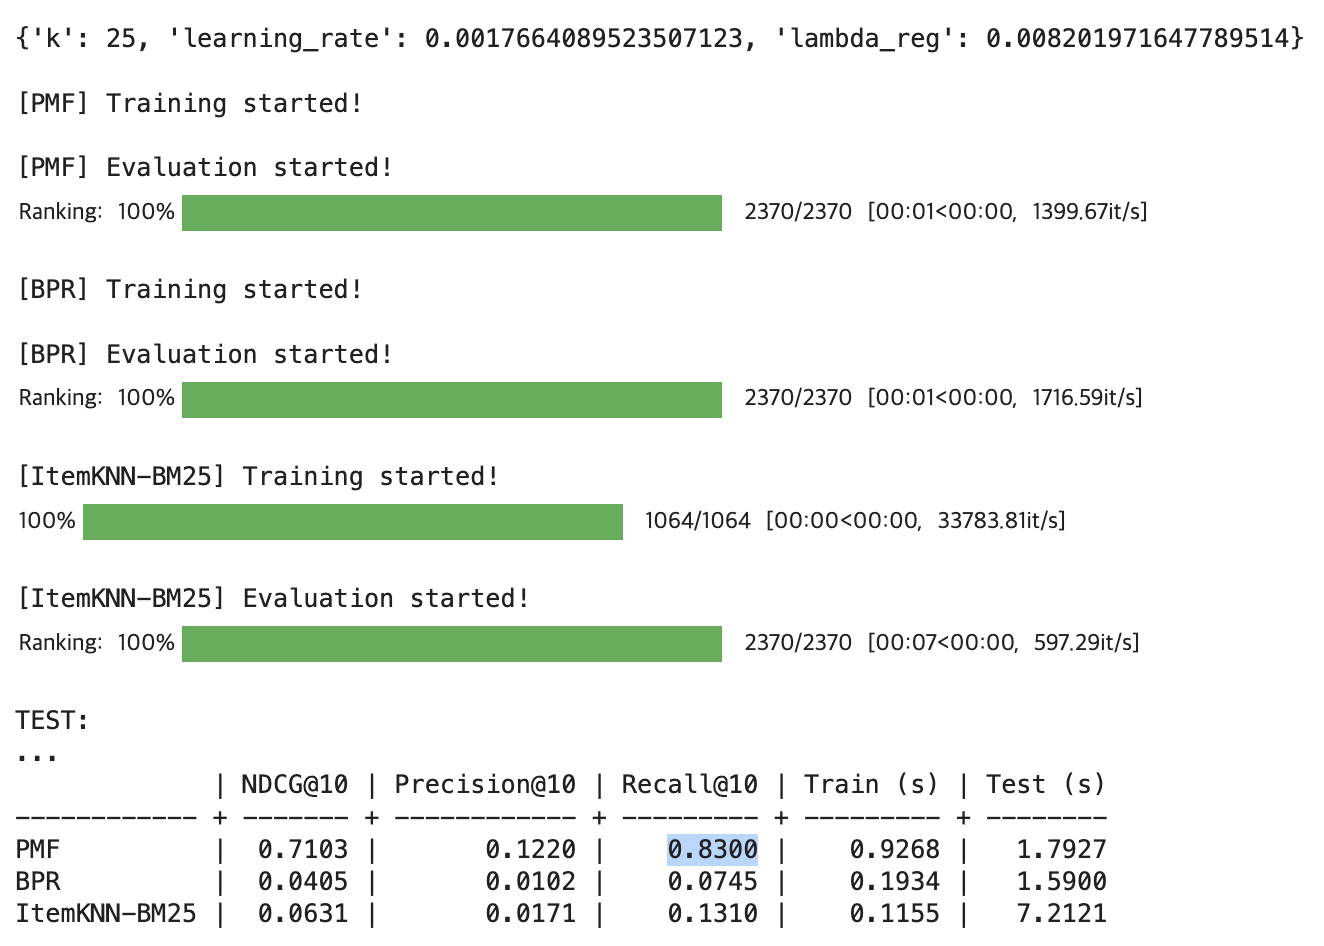

## Finally Save Model - PMF


In [58]:
import cornac

# Item Feature Modality 설정
item_feature_modality = cornac.data.FeatureModality(data=item_feature_dict)
user_feature_modality = cornac.data.FeatureModality(data=user_feature_dict)

# Split data based on ratio
rs = cornac.eval_methods.RatioSplit(
    data=dataset, test_size=0.2, rating_threshold=4.0, seed=123,
    item_feature=item_feature_modality, user_feature=user_feature_modality, verbose=True
)

pmf = cornac.models.PMF(
    k=25, max_iter=100, learning_rate=0.001766, lambda_reg=0.0082019, seed=123
)
most_pop = cornac.models.MostPop()

# Define metrics used to evaluate the models
mae = cornac.metrics.MAE()
rmse = cornac.metrics.RMSE()
prec = cornac.metrics.Precision(k=10)
recall = cornac.metrics.Recall(k=10)
ndcg = cornac.metrics.NDCG(k=10)
auc = cornac.metrics.AUC()
mAP = cornac.metrics.MAP()

# Put it together into an experiment and run
exp = cornac.Experiment(
    eval_method=rs,
    models=[pmf],
    metrics=[mae, rmse, prec, recall, ndcg, auc, mAP],
    user_based=True,
    save_dir="save_models"
)

exp.run()

rating_threshold = 4.0
exclude_unknowns = True
---
Training data:
Number of users = 3501
Number of items = 1064
Number of ratings = 10835
Max rating = 5.0
Min rating = 1.0
Global mean = 4.1
---
Test data:
Number of users = 3501
Number of items = 1064
Number of ratings = 4044
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 3501
Total items = 1064

[PMF] Training started!


/usr/local/lib/python3.10/dist-packages/cornac/data/dataset.py:335: UserWarning: 7190 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
/usr/local/lib/python3.10/dist-packages/cornac/data/dataset.py:335: UserWarning: 399 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)



[PMF] Evaluation started!


Rating:   0%|          | 0/4044 [00:00<?, ?it/s]

Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


TEST:
...
    |    MAE |   RMSE |    AUC |    MAP | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
--- + ------ + ------ + ------ + ------ + ------- + ------------ + --------- + --------- + --------
PMF | 0.4232 | 0.4501 | 0.9756 | 0.6605 |  0.7146 |       0.1211 |    0.8306 |    0.8722 |   3.7513



## Make Inferences using Model PMF

In [21]:
dataset[:10]

[(0.0, 2210300003.0, 5.0),
 (1.0, 2210220007.0, 2.0),
 (2.0, 2209070004.0, 5.0),
 (3.0, 2208200006.0, 4.0),
 (4.0, 2208260005.0, 5.0),
 (5.0, 2211060002.0, 5.0),
 (6.0, 2210040001.0, 4.0),
 (7.0, 2210270003.0, 5.0),
 (8.0, 2210270002.0, 3.0),
 (9.0, 2211130002.0, 3.0)]

In [22]:
user_id = 1.0
item_id = 2211130002.0

train_set = pmf.train_set

# Cornac의 학습 데이터에서 user_id와 item_id의 인덱스 찾기
user_idx = train_set.uid_map[user_id]  # user_id를 user_idx로 변환
item_idx = train_set.iid_map[item_id]  # item_id를 item_idx로 변환

prediction = pmf.score(user_idx=user_idx, item_idx=item_idx)

In [23]:
print(prediction)

2.809684852792727


In [29]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_items(model, target_item_id, N):
    # 학습된 PMF 모델에서 아이템 임베딩을 추출
    item_embeddings = pmf.get_item_vectors()  # 아이템 임베딩 행렬

    # 학습된 데이터셋 (item_idx와 item_id 매핑을 위해)
    train_set = pmf.train_set

    # item_id를 item_idx로 변환
    if target_item_id in train_set.iid_map:
        target_item_idx = train_set.iid_map[target_item_id]
    else:
        raise ValueError(f"Item ID {target_item_id} not found in the training set.")

    # 대상 아이템의 임베딩 벡터
    target_item_embedding = item_embeddings[target_item_idx].reshape(1, -1)

    # 모든 아이템 간의 코사인 유사도 계산
    similarities = cosine_similarity(target_item_embedding, item_embeddings).flatten()

    # 유사도가 높은 상위 N개 아이템의 인덱스 (자기 자신 제외)
    similar_item_indices = np.argsort(similarities)[::-1][1:N+1]  # 자기 자신 제외하고 상위 N개

    # 상위 N개 아이템의 ID 반환
    similar_items = [train_set.item_ids[idx] for idx in similar_item_indices]

    return similar_items

def get_item_info(item_id):
    item_info = merged_df[merged_df['VISIT_AREA_ID'] == int(item_id)]
    return item_info['VISIT_AREA_NM'].values[0], item_info['VISIT_AREA_TYPE_CD'].values[0]

In [30]:
df.head()

,userID,itemID,rating,timestamp
0,0,2210300003,5.0,2022-10-30
1,1,2210220007,2.0,2022-10-22
2,2,2209070004,5.0,2022-09-07
3,3,2208200006,4.0,2022-08-20
4,4,2208260005,5.0,2022-08-26


In [31]:
merged_df.head()

,VISIT_AREA_ID,TRAVEL_ID,VISIT_ORDER,VISIT_AREA_NM,VISIT_START_YMD,VISIT_END_YMD,ROAD_NM_ADDR,LOTNO_ADDR,X_COORD,Y_COORD,...,POI_NM,RESIDENCE_TIME_MIN,VISIT_AREA_TYPE_CD,REVISIT_YN,VISIT_CHC_REASON_CD,LODGING_TYPE_CD,DGSTFN,REVISIT_INTENTION,RCMDTN_INTENTION,SGG_CD
0,2210300003,a_a008632,7,송도센트럴파크,2022-10-30,2022-10-30,NaN,인천 연수구 송도동 24-5,126.638630,37.39306396,...,스트롤링가든브릿지,120.0,1,N,1.0,NaN,4.0,5.0,4.0,NaN
1,2210220007,d_d004269,11,원앙폭포,2022-10-22,2022-10-22,제주특별자치도 서귀포시 돈내코로 137,제주특별자치도 서귀포시 상효동 1463,126.581330,33.30017689,...,NaN,30.0,1,N,9.0,NaN,3.0,2.0,3.0,NaN
2,2209070004,c_c000751,11,쏠비치진도 인피니티풀,2022-09-07,2022-09-07,전남 진도군 의신면 송군길 30-40,전남 진도군 의신면 초사리 1204,126.327957,34.40073398,...,NaN,480.0,6,N,5.0,NaN,5.0,5.0,5.0,NaN
3,2208200006,d_d000233,18,소노캄제주 수영장,2022-08-20,2022-08-20,일주동로6347-17,제주특별자치도 서귀포시 표선면,126.792098,33.3055558,...,NaN,120.0,6,N,7.0,NaN,4.0,4.0,4.0,50130.0
4,2208260005,d_d000480,18,정방폭포,2022-08-26,2022-08-26,NaN,제주특별자치도 서귀포시 동홍동 299-3,126.571605,33.24499661,...,정방폭포,30.0,1,Y,2.0,NaN,5.0,5.0,5.0,NaN


In [32]:
merged_df.columns

Index(['VISIT_AREA_ID', 'TRAVEL_ID', 'VISIT_ORDER', 'VISIT_AREA_NM',
       'VISIT_START_YMD', 'VISIT_END_YMD', 'ROAD_NM_ADDR', 'LOTNO_ADDR',
       'X_COORD', 'Y_COORD', 'ROAD_NM_CD', 'LOTNO_CD', 'POI_ID', 'POI_NM',
       'RESIDENCE_TIME_MIN', 'VISIT_AREA_TYPE_CD', 'REVISIT_YN',
       'VISIT_CHC_REASON_CD', 'LODGING_TYPE_CD', 'DGSTFN', 'REVISIT_INTENTION',
       'RCMDTN_INTENTION', 'SGG_CD'],
      dtype='object')

In [33]:
result = set()
target_item_id = 2210300003.0
target_name, target_type = get_item_info(target_item_id)
print(f"Target Item : {target_name}, {target_type}")

print("Recommended Items")
similar_items = find_similar_items(pmf, target_item_id, 10)

for item in similar_items:
    item_info = merged_df[merged_df['VISIT_AREA_ID'] == int(item)]
    print("--------------------")
    item_name, item_type = get_item_info(item)
    print(f"Name: {item_name}, Type: {item_type}")
    result.add(item_name)

Target Item : 송도센트럴파크, 1
Recommended Items
--------------------
Name: 한라수목원, Type: 1
--------------------
Name: 제주동문재래시장, Type: 4
--------------------
Name: 홈플러스 서귀포점, Type: 4
--------------------
Name: 서귀포매일올레시장, Type: 4
--------------------
Name: 이호테우해수욕장, Type: 1
--------------------
Name: 고성오일시장, Type: 4
--------------------
Name: 아쿠아플라넷 제주, Type: 6
--------------------
Name: 루나피크닉, Type: 1
--------------------
Name: 안덕산방도서관, Type: 3
--------------------
Name: 천지연폭포, Type: 1


In [34]:
result

{'고성오일시장',
 '루나피크닉',
 '서귀포매일올레시장',
 '아쿠아플라넷 제주',
 '안덕산방도서관',
 '이호테우해수욕장',
 '제주동문재래시장',
 '천지연폭포',
 '한라수목원',
 '홈플러스 서귀포점'}